# Softmax regression (d2l)

In [17]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

In [1]:
from IPython import display
from d2l import torch as d2l

## utils

In [5]:
def load_data_fashion_mnist(batch_size, resize=None, n_workers = 4):  #@save
    """ 讀 Fashion-MNIST 的 function  
    args:
      - batch_size: 做 DataLoader 時要用的
      - resize: 例如 (224, 224), 最一開始讀檔時，trans 要用的. 
      - n_workers
    output:
      - trainning 的 iterator 和 testing 的 iterator
    """
    # transformation
    trans = [transforms.ToTensor()] # transforms.ToTensor() 會把 PIL 物件(uint8, 0~255 int) 先轉成 float32, normalize 到 0~1 之間, 再轉成 tensor (channel first, 灰階是 1)
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    
    # dataset
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    
    # dataloader
    train_loader = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers= n_workers)
    test_loader = data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers= n_workers)
    
    return (train_loader, test_loader)

In [7]:
def get_fashion_mnist_labels(labels):  #@save
    """
    原本的 label 是 0-9 的 int, 現在把他轉成 text labels
    args:
      - labels: list, 每個 element 都是 0-9 的 int
    """
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [39]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """
    args:
      - imgs: tensor; shape = (batch_size, h, w) for 灰階; (batch_size, h, w, c) for RGB; 所以要先幫他轉成 channel last
      - num_rows
      - num_cols
      
    """
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    
    max_num_imgs = np.min([num_cols*num_rows, imgs.shape[0]])
    
    for i, (ax, img) in enumerate(zip(axes, imgs[:max_num_imgs])):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            # PIL圖片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

## 讀檔

In [40]:
batch_size = 32

train_iter, test_iter = load_data_fashion_mnist(batch_size)

In [41]:
X, y = next(iter(train_iter))
print(X.shape)
print(X.dtype)
print(X.min())
print(X.max())

torch.Size([32, 1, 28, 28])
torch.float32
tensor(0.)
tensor(1.)


In [42]:
y

tensor([4, 2, 4, 7, 1, 9, 7, 2, 5, 9, 7, 1, 8, 1, 5, 6, 7, 6, 2, 5, 8, 0, 5, 9,
        8, 9, 9, 9, 8, 8, 4, 0])

In [43]:
get_fashion_mnist_labels(y)

['coat',
 'pullover',
 'coat',
 'sneaker',
 'trouser',
 'ankle boot',
 'sneaker',
 'pullover',
 'sandal',
 'ankle boot',
 'sneaker',
 'trouser',
 'bag',
 'trouser',
 'sandal',
 'shirt',
 'sneaker',
 'shirt',
 'pullover',
 'sandal',
 'bag',
 't-shirt',
 'sandal',
 'ankle boot',
 'bag',
 'ankle boot',
 'ankle boot',
 'ankle boot',
 'bag',
 'bag',
 'coat',
 't-shirt']

* 畫個圖來看看

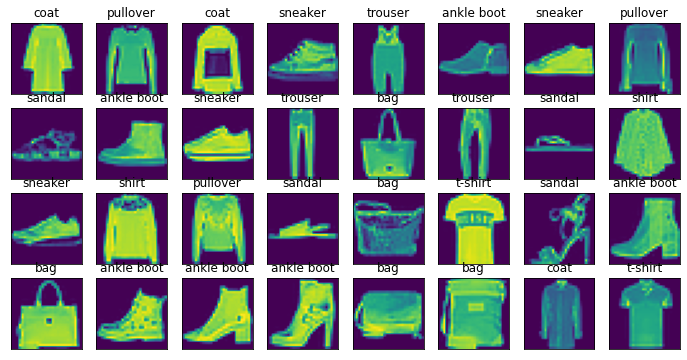

In [46]:
show_images(X.reshape(32, 28, 28), num_rows = 4, num_cols = 8, titles = get_fashion_mnist_labels(y));

## from scratch

### 定義模型


* 假設圖形拉成向量後是 p 維，然後 label 的 class 有 c 類，那從圖形的角度來理解 softmax，就是:
  * input層: p 個 neuron
  * 第一層： c 個 neuron  
  * output: 把 c 個 neruon 做 softmax，使其 c 個 output 值的加總為 1
* 用數學來表達的話(順便把 batch_size = n 也帶入)，符號可定義為：
  * $\mathbf{Y} \in \mathbb{R}^{n \times c}$, label 矩陣， n個樣本，每個樣本都是 1xc 的 one-hot encoding. 
  * $\mathbf{X} \in \mathbb{R}^{n \times p}$, 資料矩陣, n個樣本，每個樣本都是 1xp 的 vector (像素拉成向量)  
  * $\mathbf{W} \in \mathbb{R}^{p \times c}$, 權重矩陣，shape = (p, c)，input p 個 neuron，ouput c 個 neuron
  * $\mathbf{b} \in \mathbb{R}^{1\times c}$, bias 向量, shape = (1, c)
* 式子為：

$$ \begin{aligned} \mathbf{O} &= \mathbf{X} \mathbf{W} + \mathbf{b}, \\ \hat{\mathbf{Y}} & = \mathrm{softmax}(\mathbf{O}). \end{aligned} $$

* softmax 是對 $\hat{\mathbf{y}}$ 的每一列做，做完後，每一列所有element的加總為 1

$$
\mathrm{softmax}(\mathbf{O})_{ij} = \frac{\exp(\mathbf{O}_{ij})}{\sum_k \exp(\mathbf{O}_{ik})}.
$$

* 來定義一下 softmax function

In [160]:
def softmax(X):
    X_exp = torch.exp(X) # 每個 element 都先取 exp
    partition = X_exp.sum(1, keepdim=True) # 對每一列取 sum
    return X_exp / partition  # 這裡用了 broadcasting

* 試試看：

In [49]:
X = torch.normal(0, 1, (2, 5))
X

tensor([[ 0.7939, -0.0138,  0.0116, -0.1706,  0.4581],
        [-0.5037,  1.1059,  0.2747, -1.3178,  1.5509]])

In [50]:
X_prob = softmax(X)
X_prob

tensor([[0.3334, 0.1487, 0.1525, 0.1271, 0.2383],
        [0.0609, 0.3045, 0.1326, 0.0270, 0.4751]])

In [51]:
X_prob.sum(1)

tensor([1.0000, 1.0000])

* 現在，可以來定義模型了：

In [161]:
def model(X, params):
    """ softmax regression """
    W, b = params
    O = torch.matmul(X.reshape((-1, W.shape[0])), W) + b
    Y_hat = softmax(O)
    return Y_hat     

### loss function

* 假設 y 有 C 個 class，資料筆數為 n，那：  
  * y 為 nxc matrix，每一列都是 one-hot encoding. 
  * y_hat 為 nxc matrix，每一列是 c 個 class 的 predict probability
* categorical cross entropy 被定義為：  $\frac{1}{n} \sum_{i=1}^n \left( - \sum_{j=1}^C y_{ij} log \hat{y_{ij}}\right)$  
* 其中，loss 就是中間那項 $- \sum_{j=1}^C y_{ij} log \hat{y_{ij}}$，cost 是用 mean 來 summarise (你要用 sum 來 summarise 也可以)  
* 一般來說，$y_i$ 不是 one-hot encoding，就是 index encoding (e.g. 總共 c 類，那 y 的值域為 0 到 c-1)，在這種情況下，index encoding 的計算方法比較簡單，他就挑 y = 1 的 y_hat 出來即可
* 但之後會慢慢接觸到，y 可能是 mix-up 的結果，也就是說， y 仍是 c 維 vector，只是它不是 one-hot 了，他是 c 個 probability. 
* 那我們仍然可以用上面的定義去計算 cross entropy，此時的解釋，就會變成去看 y 和 y_hat 的 distributioin 像不像

* 現在，來自己寫兩個 loss function，一個給 one-hot encoding 用，一個給 index encoding 用:

In [162]:
class MyCategoricalCrossEntropy:
    def __init__(self, reduction = "mean"):
        self.reduction = reduction
    def __call__(self, y_hat_mat, y_mat):
        """
        args:
          - y_hat_mat: shape = (batch_size, c), c = one_hot_vector_size
          - y_mat: shape = (batch_size, c), c = one_hot_vector_size
        """
        log_y_hat_mat = torch.log(y_hat_mat)
        loss = y_mat*log_y_hat_mat
        loss = -1*loss.sum(1)
        if self.reduction == "mean":
            cost = loss.mean()
        if self.reduction == "sum":
            cost = loss.sum()
        if self.reduction == "none":
            cost = loss
        return cost

In [127]:
# instance
loss = MyCategoricalCrossEntropy(reduction = "none")
y_hat_logit_mat = np.array(
    [[-2.3, 4, 1.5],
     [-5, 2, 8]]
)
y_hat_logit_mat = torch.tensor(y_hat_logit_mat)

y_hat_mat = softmax(y_hat_logit_mat)
# y_hat_mat = np.array(
#     [[0.2, 0.2, 0.6],
#      [0.1, 0.8, 0.1]]
# )
y_mat = np.array(
    [[0, 0, 1],
     [0, 1, 0]]
)

y_hat_mat = torch.tensor(y_hat_mat)
y_mat = torch.tensor(y_mat)
loss(y_hat_mat, y_mat)

<ipython-input-127-90f11e6105ed>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_hat_mat = torch.tensor(y_hat_mat)


tensor([2.5806, 6.0025], dtype=torch.float64)

In [128]:
y_mat = np.array(
    [[0, 0, 1],
     [0, 1, 0]]
)
y_mat = torch.tensor(y_mat, dtype = torch.float32)
y_mat

tensor([[0., 0., 1.],
        [0., 1., 0.]])

In [123]:
y_hat_mat = np.array(
    [[0.2, 0.2, 0.6],
     [0.1, 0.8, 0.1]]
)
y_hat_mat = torch.tensor(y_hat_mat)
y_hat_mat = torch.log(y_hat_mat/(1-y_hat_mat))
y_hat_mat

tensor([[-1.3863, -1.3863,  0.4055],
        [-2.1972,  1.3863, -2.1972]], dtype=torch.float64)

In [131]:
from torch import nn
official_loss = nn.CrossEntropyLoss(reduction='none')
official_loss(y_hat_logit_mat, y_mat)

tensor([2.5806, 6.0025], dtype=torch.float64)

In [121]:
official_loss(y_hat_mat, y_vec)

tensor([0.8504, 0.6897], dtype=torch.float64)

In [163]:
class MySparseCategoricalCrossEntropy:
    def __init__(self, reduction = "mean"):
        self.reduction = reduction
    def __call__(self, y_hat_mat, y_vec):
        """
        args:
          - y_hat_mat: shape = (batch_size, c), c = one_hot_vector_size
          - y_vec: shape = (batch_size,), 每個 element 是 int，值介於 0~ (c-1)
        """
        loss = -1*torch.log(y_hat_mat[range(len(y_hat_mat)), y_vec])
        if self.reduction == "mean":
            cost = loss.mean()
        if self.reduction == "sum":
            cost = loss.sum()
        if self.reduction == "none":
            cost = loss
        return cost

In [63]:
# instance
loss = MySparseCategoricalCrossEntropy(reduction = "none")
y_hat_mat = np.array(
    [[0.2, 0.2, 0.6],
     [0.1, 0.8, 0.1]]
)
y_hat_mat = torch.tensor(y_hat_mat)

y_vec = np.array([2, 1])
y_vec = torch.tensor(y_vec)

loss(y_hat_mat, y_vec)

tensor([0.5108, 0.2231], dtype=torch.float64)

### optimizer

* 一樣用 sgd 就好：

In [164]:
class MySGD:
    def __init__(self, params, lr = 0.03):
        self.params = params
        self.lr = lr
    
    def step(self):
        with torch.no_grad():
            for param in self.params:
                param -= self.lr * param.grad
                
    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_() # 清空 gradient
# def optimizer(params, lr = 0.03):  #@save
#     """ sgd """
#     with torch.no_grad():
#         for param in params:
#             param -= lr * param.grad
#             param.grad.zero_() # 清空 gradient

### metric

In [165]:
class MyAcc:
    def __init__(self, threshold=0.5, **kwargs):
        self.threshold = 0.5
        self.true_decision = 0.0
        self.total_number = 0.0
    def update_state(self, y_hat, y):
        # 計算預測正確的數量
        if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
            y_hat = y_hat.argmax(axis = 1)
        cmp = y_hat.type(y.dtype) == y
        self.true_decision += float(cmp.type(y.dtype).sum())
        self.total_number += len(y)

    def result(self):
        if self.total_number == 0:
            accuracy = 0.0
        else:
            accuracy = self.true_decision / self.total_number
        return accuracy

    def reset_state(self):
        self.true_decision = 0.0
        self.total_number = 0.0

In [141]:
my_acc = MyAcc()

In [145]:
y_hat = torch.tensor([[0.2, 0.6, 0.2],[0.1,0.1,0.8],[0.9,0.05,0.05]], requires_grad = False)
y = torch.tensor([0, 2, 0], requires_grad = False)

In [146]:
my_acc.update_state(y_hat, y)
my_acc.result()

0.6666666666666666

In [147]:
my_acc.update_state(y_hat, y)
my_acc.result()

0.6666666666666666

In [148]:
my_acc.reset_state()

In [149]:
my_acc.result()

0.0

### training

* 這次，來定義一些好用的 function 吧：

In [166]:
def train_epoch(model, train_iter, loss, optimizer, metric):
    metric.reset_state()
    cost_list = []
    for batch, (X, y) in enumerate(train_iter):
        
        # forward
        if isinstance(model, torch.nn.Module):
            model.train()
            y_hat = model(X)
        else:
            y_hat = model(X, params)
        batch_cost = loss(y_hat, y)
        metric.update_state(y_hat, y)
        
        # 清空 gradient
        optimizer.zero_grad()
        
        # backward
        batch_cost.backward() # 算 gradient
        optimizer.step() # 更新參數
        
        # add to cost_list
        cost_list.append(batch_cost.item())
        
        if batch % 300 == 0:
            current_cost = np.array(cost_list).mean()
            print(f"batch {batch + 1} training loss: {current_cost}; training accuracy: {metric.result()}")
    
    epoch_cost = np.array(cost_list).mean()
    epoch_acc = metric.result()
    return epoch_cost, epoch_acc

In [167]:
def valid_epoch(model, test_iter, loss, metric):
    
    metric.reset_state()
    
    if isinstance(model, torch.nn.Module):
        model.eval()
    with torch.no_grad():
        cost_list = []
        for X, y in test_iter:
            # forward only
            if isinstance(model, torch.nn.Module):
                y_hat = model(X)
            else:
                y_hat = model(X, params)
            batch_cost = loss(y_hat, y)
            cost_list.append(batch_cost.item())
            metric.update_state(y_hat, y)
            
    epoch_cost = np.array(cost_list).mean()
    epoch_acc = metric.result()
    return epoch_cost, epoch_acc

In [168]:
def train(model, train_iter, test_iter, loss, num_epochs, optimizer, metric):  #@save
    train_history = []
    valid_history = []
    for epoch in range(num_epochs):
        print(f"---------- epoch: {epoch+1} ----------")
        
        train_epoch_cost, train_epoch_acc = train_epoch(model, train_iter, loss, optimizer, metric)
        valid_epoch_cost, valid_epoch_acc = valid_epoch(model, test_iter, loss, metric)
        
        print(f"training loss: {train_epoch_cost}; validation loss: {valid_epoch_cost}")
        print(f"training acc: {train_epoch_acc}; validation acc: {valid_epoch_acc}")
        print("")
        train_history.append({"loss": train_epoch_cost, "acc": train_epoch_acc})
        valid_history.append({"loss": valid_epoch_cost, "acc": valid_epoch_acc})
    return train_history, valid_history

In [169]:
# hyper-parameter
num_epochs = 10
learning_rate = 0.1


# 初始化參數
num_inputs = 28*28
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)
params = [W, b]

# loss
loss =  MySparseCategoricalCrossEntropy()

# optimizer
optimizer = MySGD(params, lr = learning_rate)

# metric
metric = MyAcc()

# training
train_history, valid_history = train(model, train_iter, test_iter, loss, num_epochs, optimizer, metric)

---------- epoch: 1 ----------
batch 1 training loss: 2.2930948734283447; training accuracy: 0.03125
batch 301 training loss: 0.8190287714978786; training accuracy: 0.7291320598006644
batch 601 training loss: 0.7239517746570702; training accuracy: 0.7584234608985025
batch 901 training loss: 0.6713733558484108; training accuracy: 0.7761861820199778
batch 1201 training loss: 0.6385236556310638; training accuracy: 0.7858295170691091
batch 1501 training loss: 0.6109974273119984; training accuracy: 0.7948034643570953
batch 1801 training loss: 0.5959260584760678; training accuracy: 0.7991220155469184
training loss: 0.5925289306561152; validation loss: 0.5071188468997851
training acc: 0.8003166666666667; validation acc: 0.8237

---------- epoch: 2 ----------
batch 1 training loss: 0.6844662427902222; training accuracy: 0.8125
batch 301 training loss: 0.49228916997925387; training accuracy: 0.8324335548172758
batch 601 training loss: 0.4993857322090279; training accuracy: 0.8273190515806988
ba

### prediction

现在训练已经完成，我们的模型已经准备好[**对图像进行分类预测**]。
给定一系列图像，我们将比较它们的实际标签（文本输出的第一行）和模型预测（文本输出的第二行）。


tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8])


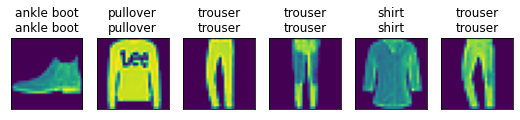

In [113]:
def my_predict(model, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break # 只取第一個 batch 的意思
    print(y)
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(model(X, params).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

my_predict(model, test_iter)

## 內建 function

### 定義模型

In [132]:
from torch import nn
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 10)
)

### loss function

* 用內建的 `nn.CrossEntropyLoss()`，使用方法和之前一樣： `loss = nn.CrossEntropyLoss()`，然後`loss(y_hat, y)`
* 要注意的是：  
  * y_hat 要放的是 logits (還沒做 softmax)的結果。這樣做的原因，是因為數值的穩定性的考量. 
  * y 可以放 [0, C) 的 integer，或是 one-hot encoding (但 dtype 要改為 float32，原因是可以通用到 blended-label). 

In [133]:
loss = nn.CrossEntropyLoss(reduction='mean')

### optimizer

In [134]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

### metric

In [155]:
metric = MyAcc()

### training

In [159]:
train_history, valid_history = train(model, train_iter, test_iter, loss, num_epochs, optimizer, metric)

---------- epoch: 1 ----------
batch 1 training loss: 0.2760540843009949; training accuracy: 0.90625
batch 301 training loss: 0.4194850102562049; training accuracy: 0.8523671096345515
batch 601 training loss: 0.4186703875884042; training accuracy: 0.8544093178036606
batch 901 training loss: 0.4168739371936144; training accuracy: 0.853808268590455
batch 1201 training loss: 0.41391293170375687; training accuracy: 0.8543921731890092
batch 1501 training loss: 0.4162772057961417; training accuracy: 0.8542638241172552
batch 1801 training loss: 0.41838816321273437; training accuracy: 0.8537791504719601
training loss: 0.42017893958886465; validation loss: 0.4601927140412239
training acc: 0.8530666666666666; validation acc: 0.8414

---------- epoch: 2 ----------
batch 1 training loss: 0.39312267303466797; training accuracy: 0.8125
batch 301 training loss: 0.407473469914194; training accuracy: 0.8565199335548173
batch 601 training loss: 0.40750258228743136; training accuracy: 0.8571651414309485


## 內建 VS 自己寫的差別

* 主要在 loss function，內建的 `nn.CrossEntropyLoss()` 放進去的 y_hat 必須是 logits，不能是 softmax 後的機率值。
* 所以，在定義模型時，內建的 model，必須將輸定為 logit (i.e. 只用 linear 層，沒有用 nn.softmax() 層)，但自己 from scratch 建的時候，model 的輸出是要經過 softmax 的處理
* 至於，為啥內建 `nn.CrossEntropyLoss()` 一定要餵 logits 給他，是因為數值穩定性的考量
* d2l 的 `3.7 Softmax回歸的簡潔實現` 有很清楚的說明，再去看就好，有空再整理過來。